In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from utils import *
from keras.models import Model, load_model, Sequential
from keras.layers import Dense,Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

2022-12-22 23:21:52.946963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 23:21:53.127086: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 23:21:53.905211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-22 23:21:53.905321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [128]:
from utils import *

# Test

In [13]:
slide_nums = ['078','081', '091', '094', '096']
slide_paths = []
tumor_mask_paths = []
slide_windows1 = []
slide_windows2 = []
window_labels = []
for slide_num in slide_nums:
  slide_paths.append('tumor_' + slide_num + '.tif')
  tumor_mask_paths.append('tumor_' + slide_num + '_mask.tif')
for i in range(len(slide_paths)):
    window_1, window_2, labels = get_windows(slide_paths[i], tumor_mask_paths[i], (2,3), 
                                             stride=150, window_len=299)
    slide_windows1.extend(window_1)
    slide_windows2.extend(window_2)
    window_labels.extend(labels)


    

In [23]:
len(slide_windows1)

19132

In [24]:
len(slide_windows1)

19132

In [17]:
labels = np.array(window_labels)

In [19]:
w_tumor, w_tumor2, wo_tumor, wo_tumor2 = shuffle_data(slide_windows1, slide_windows2, window_labels)

In [20]:
len(w_tumor2)


3834

In [21]:
len(wo_tumor2)

3834

In [ ]:
# del slide_windows1
# del slide_windows2
# del window_labels

# Split dataset 

In [25]:
label_pos = np.ones(len(w_tumor))
label_neg = np.zeros(len(wo_tumor))
assert len(label_pos)==len(label_pos)

In [26]:
images1 = np.concatenate((w_tumor,wo_tumor), axis=0)
images2 = np.concatenate((w_tumor2,wo_tumor2), axis=0)
labels = np.concatenate((label_pos, label_neg))

In [27]:
len(labels)

7668

In [28]:

shuffle = np.arange(len(labels))
np.random.shuffle(shuffle)

ds_images1 = np.array([images1[i] for i in shuffle])
ds_images2 = np.array([images2[i] for i in shuffle])
ds_labels = np.array([labels[i] for i in shuffle])
# ds_labels2 = np.array([labels[i] for i in shuffle])

In [29]:
ds_images1.shape

(7668, 299, 299, 3)

In [30]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(ds_images1, ds_labels, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(ds_images2, ds_labels, test_size=0.2, shuffle=False)

In [31]:
with open('train1.npy', 'wb') as f:
    np.save(f, X_train1)
    np.save(f, y_train1)

with open('test1.npy', 'wb') as f:
    np.save(f, X_test1)
    np.save(f, y_test1)

In [32]:
with open('train2.npy', 'wb') as f:
    np.save(f, X_train2)
    np.save(f, y_train2)

with open('test2.npy', 'wb') as f:
    np.save(f, X_test2)
    np.save(f, y_test2)

# Load

In [5]:
with open('train1.npy', 'rb') as f:
    X_train1 = np.load(f)
    y_train1 = np.load(f)

In [6]:
with open('train2.npy', 'rb') as f:
    X_train2 = np.load(f)
    y_train2 = np.load(f)

In [7]:
with open('test1.npy', 'rb') as f:
    X_test1 = np.load(f)
    y_test1 = np.load(f)

In [8]:
with open('test2.npy', 'rb') as f:
    X_test2 = np.load(f)
    y_test2 = np.load(f)

In [9]:
len(y_test1)

1534

In [10]:
len(y_train1)

6134

In [11]:
X_train1.shape

(6134, 299, 299, 3)

In [12]:
1534//16

95

# Build Model

In [15]:
type(X_train1)

numpy.ndarray

In [12]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense,Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
X_train1 = preprocess(X_train1)
X_train2 = preprocess(X_train2)
X_test1 = preprocess(X_test1)
X_test2 = preprocess(X_test2)

In [18]:
t = X_train1[0:16]

In [19]:
t.shape

(16, 299, 299, 3)

In [14]:
arr = np.concatenate([X_train1, X_test1])

In [15]:
arr.shape

(7668, 299, 299, 3)

In [16]:
arr2 = np.concatenate([X_train2, X_test2])

In [17]:
label = np.concatenate([y_train1, y_test1])

In [18]:
label.shape

(7668,)

In [19]:
w_tumor, w_tumor2, wo_tumor, wo_tumor2 = cut_data(arr, arr2, label, size = 1250)


In [20]:
del arr, arr2, label

In [21]:
len(w_tumor)

1250

In [22]:
label_pos = np.ones(len(w_tumor))
label_neg = np.zeros(len(wo_tumor))
assert len(label_pos)==len(label_pos)

images1 = np.concatenate((w_tumor,wo_tumor), axis=0)
images2 = np.concatenate((w_tumor2,wo_tumor2), axis=0)
labels = np.concatenate((label_pos, label_neg))

len(labels)


shuffle = np.arange(len(labels))
np.random.shuffle(shuffle)

ds_images1 = np.array([images1[i] for i in shuffle])
ds_images2 = np.array([images2[i] for i in shuffle])
ds_labels = np.array([labels[i] for i in shuffle])
# ds_labels2 = np.array([labels[i] for i in shuffle])

ds_images1.shape

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(ds_images1, ds_labels, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(ds_images2, ds_labels, test_size=0.2, shuffle=False)

# Save!!!!!!!!!

In [23]:
with open('train1_s.npy', 'wb') as f:
    np.save(f, X_train1)
    np.save(f, y_train1)

with open('test1_s.npy', 'wb') as f:
    np.save(f, X_test1)
    np.save(f, y_test1)

with open('train2_s.npy', 'wb') as f:
    np.save(f, X_train2)
    np.save(f, y_train2)

with open('test2_s.npy', 'wb') as f:
    np.save(f, X_test2)
    np.save(f, y_test2)

In [ ]:
# def gen_train():
#     for i in range(0,len(X_train1), 16):
#         train_1 = X_train1[i:i+16]
#         train_2 = X_train2[i:i+16]
#         label = y_train1[i:i+16]
#         batch_x = [train_1, train_2]
#         batch_y = label
#         yield (batch_x, batch_y)


In [ ]:
# sess = tf.InteractiveSession()
# def create_dataset():
#     data = tf.data.Dataset.from_generator(gen, (tf.float32, tf.float32, tf.int32))
#     data = data.batch(16)
#     data = data.prefetch(16)
#     data = data.make_one_shot_iterator()
    
    
    

In [21]:
# final_ds = tf.Tensor()
# for i in range(0, len(X_train1), 16):
#     train_ds_1 = tf.data.Dataset.from_tensor_slices(X_train1[i:i+16])
#     #image_ds_1 = train_ds_1.map(preprocess)

#     train_ds_2 = tf.data.Dataset.from_tensor_slices(X_train2[i:i+16])
#     #image_ds_2 = train_ds_2.map(preprocess)
    
#     label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train1[i:i+16], tf.int64))

#     image_ds = tf.data.Dataset.zip(((train_ds_1,train_ds_2), label_ds))
#     final_ds = tf.concate(final_ds, image_ds)
    

TypeError: __init__() missing 3 required positional arguments: 'op', 'value_index', and 'dtype'

# Load !!!!!

In [4]:
with open('train1_s.npy', 'rb') as f:
    X_train1 = np.load(f)
    y_train1 = np.load(f)

with open('train2_s.npy', 'rb') as f:
    X_train2 = np.load(f)
    y_train2 = np.load(f)

with open('test1_s.npy', 'rb') as f:
    X_test1 = np.load(f)
    y_test1 = np.load(f)

with open('test2_s.npy', 'rb') as f:
    X_test2 = np.load(f)
    y_test2 = np.load(f)

In [5]:
train_ds = create_tf_dataset(X_train1, X_train2, y_train2)

2022-12-22 21:43:56.324205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 21:43:56.337107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 21:43:56.338944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 21:43:56.341481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
X_train1.shape

(2000, 299, 299, 3)

In [7]:
X_test1.shape

(500, 299, 299, 3)

In [8]:
test_ds = create_tf_dataset(X_test1, X_test2, y_test2)

In [9]:

model = create_model() 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2input_2_2 (InputLayer)  [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                             

 activation_3 (Activation)      (None, 73, 73, 80)   0           ['batch_normalization_3[0][0]']  
                                                                                                  
 activation_97activation_97_2 (  (None, 73, 73, 80)  0           ['batch_normalization_97batch_nor
 Activation)                                                     malization_97_2[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)              (None, 71, 71, 192)  138240      ['activation_3[0][0]']           
                                                                                                  
 conv2d_98conv2d_98_2 (Conv2D)  (None, 71, 71, 192)  138240      ['activation_97activation_97_2[0]
                                                                 [0]']                            
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_5 (Conv2D)              (None, 35, 35, 64)   12288       ['max_pooling2d_1[0][0]']        
                                                                                                  
 conv2d_7 (Conv2D)              (None, 35, 35, 64)   76800       ['activation_6[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 35, 35, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 35, 35, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 conv2d_99conv2d_99_2 (Conv2D)  (None, 35, 35, 64)   12288       ['max_pooling2d_5max_pooling2d_5_
          

 conv2d_15 (Conv2D)             (None, 35, 35, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_109conv2d_109_2 (Conv2D  (None, 35, 35, 64)  16384       ['mixed0mixed0_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 35, 35, 64)  192         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_109batch_n  (None, 35, 35, 64)  192         ['conv2d_109conv2d_109_2[0][0]'] 
 ormalization_109_2 (BatchNorma                                                                   
 lization)

                                                                                                  
 batch_normalization_17 (BatchN  (None, 35, 35, 96)  288         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_18 (BatchN  (None, 35, 35, 64)  192         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_106batch_n  (None, 35, 35, 64)  192         ['conv2d_106conv2d_106_2[0][0]'] 
 ormalization_106_2 (BatchNorma                                                                   
 lization)                                                                                        
          

                                                                                                  
 batch_normalization_20 (BatchN  (None, 35, 35, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 35, 35, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_114batch_n  (None, 35, 35, 48)  144         ['conv2d_114conv2d_114_2[0][0]'] 
 ormalization_114_2 (BatchNorma                                                                   
 lization)                                                                                        
          

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 96)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_25 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 activation_113activation_113_2  (None, 35, 35, 64)  0           ['batch_normalization_113batch_no
  (Activation)                                                   rmalization_113_2[0][0]']        
                                                                                                  
 activation_115activation_115_2  (None, 35, 35, 64)  0           ['batch_normalization_115batch_no
  (Activation)                                                   rmalization_115_2[0][0]']        
          

 lization)                                                                                        
                                                                                                  
 batch_normalization_123batch_n  (None, 17, 17, 96)  288         ['conv2d_123conv2d_123_2[0][0]'] 
 ormalization_123_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_26 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 17, 17, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooli

 ormalization_125_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_130batch_n  (None, 17, 17, 128)  384        ['conv2d_130conv2d_130_2[0][0]'] 
 ormalization_130_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_31 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 activation_36 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_36[0][0]'] 
          

                                                                                                  
 batch_normalization_38 (BatchN  (None, 17, 17, 192)  576        ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_39 (BatchN  (None, 17, 17, 192)  576        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_124batch_n  (None, 17, 17, 192)  576        ['conv2d_124conv2d_124_2[0][0]'] 
 ormalization_124_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 ormalization_139_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_45 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 activation_139activation_139_2  (None, 17, 17, 160)  0          ['batch_normalization_139batch_no
  (Activation)                                                   rmalization_139_2[0][0]']        
                                                                                                  
 conv2d_41 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 conv2d_46

 conv2d_40 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed4[0][0]']                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 17, 17, 192)  215040      ['activation_42[0][0]']          
                                                                                                  
 conv2d_48 (Conv2D)             (None, 17, 17, 192)  215040      ['activation_47[0][0]']          
                                                                                                  
 conv2d_49 (Conv2D)             (None, 17, 17, 192)  147456      ['average_pooling2d_4[0][0]']    
                                                                                                  
 conv2d_134conv2d_134_2 (Conv2D  (None, 17, 17, 192)  147456     ['mixed4mixed4_2[0][0]']         
 )                                                                                                
          

                                                                                                  
 conv2d_148conv2d_148_2 (Conv2D  (None, 17, 17, 160)  122880     ['mixed5mixed5_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_54 (BatchN  (None, 17, 17, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_148batch_n  (None, 17, 17, 160)  480        ['conv2d_148conv2d_148_2[0][0]'] 
 ormalization_148_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 batch_normalization_146batch_n  (None, 17, 17, 160)  480        ['conv2d_146conv2d_146_2[0][0]'] 
 ormalization_146_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_151batch_n  (None, 17, 17, 160)  480        ['conv2d_151conv2d_151_2[0][0]'] 
 ormalization_151_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_52 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 activation_147activation_147_2  (None, 17, 17, 192)  0          ['batch_normalization_147batch_no
  (Activation)                                                   rmalization_147_2[0][0]']        
                                                                                                  
 activation_152activation_152_2  (None, 17, 17, 192)  0          ['batch_normalization_152batch_no
  (Activation)                                                   rmalization_152_2[0][0]']        
                                                                                                  
 activation_153activation_153_2  (None, 17, 17, 192)  0          ['batch_normalization_153batch_no
  (Activation)                                                   rmalization_153_2[0][0]']        
                                                                                                  
 mixed6 (C

                                                                                                  
 activation_66 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_66[0][0]'] 
                                                                                                  
 activation_155activation_155_2  (None, 17, 17, 192)  0          ['batch_normalization_155batch_no
  (Activation)                                                   rmalization_155_2[0][0]']        
                                                                                                  
 activation_160activation_160_2  (None, 17, 17, 192)  0          ['batch_normalization_160batch_no
  (Activation)                                                   rmalization_160_2[0][0]']        
                                                                                                  
 conv2d_62 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_61[0][0]']          
          

 ormalization_154_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_157batch_n  (None, 17, 17, 192)  576        ['conv2d_157conv2d_157_2[0][0]'] 
 ormalization_157_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_162batch_n  (None, 17, 17, 192)  576        ['conv2d_162conv2d_162_2[0][0]'] 
 ormalization_162_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 conv2d_164conv2d_164_2 (Conv2D  (None, 17, 17, 192)  147456     ['mixed7mixed7_2[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_168conv2d_168_2 (Conv2D  (None, 17, 17, 192)  258048     ['activation_167activation_167_2[
 )                                                               0][0]']                          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_80 (Conv2D)             (None, 8, 8, 448)    573440      ['mixed8[0][0]']                 
                                                                                                  
 conv2d_174conv2d_174_2 (Conv2D  (None, 8, 8, 448)   573440      ['mixed8mixed8_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_80 (BatchN  (None, 8, 8, 448)   1344        ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_174batch_n  (None, 8, 8, 448)   1344        ['conv2d_174conv2d_174_2[0][0]'] 
 ormalizat

                                                                                                  
 batch_normalization_79 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_79[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_82 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_83 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84

                                                                  'activation_173activation_173_2[
                                                                 0][0]']                          
                                                                                                  
 concatenate_2concatenate_2_2 (  (None, 8, 8, 768)   0           ['activation_176activation_176_2[
 Concatenate)                                                    0][0]',                          
                                                                  'activation_177activation_177_2[
                                                                 0][0]']                          
                                                                                                  
 activation_178activation_178_2  (None, 8, 8, 192)   0           ['batch_normalization_178batch_no
  (Activation)                                                   rmalization_178_2[0][0]']        
          

 average_pooling2d_8 (AveragePo  (None, 8, 8, 2048)  0           ['mixed9[0][0]']                 
 oling2D)                                                                                         
                                                                                                  
 conv2d_181conv2d_181_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_180activation_180_2[
 )                                                               0][0]']                          
                                                                                                  
 conv2d_182conv2d_182_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_180activation_180_2[
 )                                                               0][0]']                          
                                                                                                  
 conv2d_185conv2d_185_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_184activation_184_2[
 )        

                                                                                                  
 activation_186activation_186_2  (None, 8, 8, 384)   0           ['batch_normalization_186batch_no
  (Activation)                                                   rmalization_186_2[0][0]']        
                                                                                                  
 batch_normalization_187batch_n  (None, 8, 8, 192)   576         ['conv2d_187conv2d_187_2[0][0]'] 
 ormalization_187_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

# nb !!!!!!!!!

In [4]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [13]:
# model = multi_level_inception()

In [10]:
# Training
BATCH_SIZE = 16
model.compile(optimizer=RMSprop(learning_rate = 0.002,
                                momentum=0.9,
                                decay = 0.9,
                                epsilon = 1.0
                               ),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
#                                                   min_delta=0.001,
#                                                   patience=3,
#                                                   verbose=1)

history = model.fit(
    train_ds,
    steps_per_epoch=int(len(X_train1)/BATCH_SIZE)+1,
    epochs=10,
    validation_data=test_ds,
    validation_steps=int(len(X_test1)/BATCH_SIZE)+1,)

Epoch 1/10


2022-12-22 21:46:47.862442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


126/126 [==============================] - 93s 574ms/step - loss: 0.5457 - accuracy: 0.7599 - val_loss: 0.4174 - val_accuracy: 0.8379
Epoch 2/10
126/126 [==============================] - 69s 546ms/step - loss: 0.3289 - accuracy: 0.8606 - val_loss: 0.3385 - val_accuracy: 0.8867
Epoch 3/10
126/126 [==============================] - 68s 544ms/step - loss: 0.2967 - accuracy: 0.8800 - val_loss: 0.3240 - val_accuracy: 0.8730
Epoch 4/10
126/126 [==============================] - 68s 544ms/step - loss: 0.2732 - accuracy: 0.8894 - val_loss: 0.3173 - val_accuracy: 0.8672
Epoch 5/10
126/126 [==============================] - 69s 545ms/step - loss: 0.2582 - accuracy: 0.8953 - val_loss: 0.3115 - val_accuracy: 0.8711
Epoch 6/10
126/126 [==============================] - 68s 543ms/step - loss: 0.2470 - accuracy: 0.9058 - val_loss: 0.3075 - val_accuracy: 0.8730
Epoch 7/10
126/126 [==============================] - 68s 543ms/step - loss: 0.2379 - accuracy: 0.9092 - val_loss: 0.3040 - val_accuracy: 0.8

# No need to save

In [11]:
del X_train1, X_train2, X_test1, X_test2, y_train1, y_train2, y_test1, y_test2

In [13]:
model_filename = os.path.join('./model', "inception_rmsprop")
model.save(model_filename)

INFO:tensorflow:Assets written to: ./model/inception_rmsprop/assets


INFO:tensorflow:Assets written to: ./model/inception_rmsprop/assets


# No need to load 

In [5]:
model_filename = os.path.join('./model', "inception_rmsprop")
new_model = tf.keras.models.load_model(model_filename)

2022-12-22 23:22:27.536656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 23:22:27.548880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 23:22:27.551652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 23:22:27.554737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2input_2_2 (InputLayer)  [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                             

 activation_3 (Activation)      (None, 73, 73, 80)   0           ['batch_normalization_3[0][0]']  
                                                                                                  
 activation_97activation_97_2 (  (None, 73, 73, 80)  0           ['batch_normalization_97batch_nor
 Activation)                                                     malization_97_2[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)              (None, 71, 71, 192)  138240      ['activation_3[0][0]']           
                                                                                                  
 conv2d_98conv2d_98_2 (Conv2D)  (None, 71, 71, 192)  138240      ['activation_97activation_97_2[0]
                                                                 [0]']                            
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_5 (Conv2D)              (None, 35, 35, 64)   12288       ['max_pooling2d_1[0][0]']        
                                                                                                  
 conv2d_7 (Conv2D)              (None, 35, 35, 64)   76800       ['activation_6[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 35, 35, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 35, 35, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 conv2d_99conv2d_99_2 (Conv2D)  (None, 35, 35, 64)   12288       ['max_pooling2d_5max_pooling2d_5_
          

 conv2d_15 (Conv2D)             (None, 35, 35, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_109conv2d_109_2 (Conv2D  (None, 35, 35, 64)  16384       ['mixed0mixed0_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 35, 35, 64)  192         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_109batch_n  (None, 35, 35, 64)  192         ['conv2d_109conv2d_109_2[0][0]'] 
 ormalization_109_2 (BatchNorma                                                                   
 lization)

                                                                                                  
 batch_normalization_17 (BatchN  (None, 35, 35, 96)  288         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_18 (BatchN  (None, 35, 35, 64)  192         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_106batch_n  (None, 35, 35, 64)  192         ['conv2d_106conv2d_106_2[0][0]'] 
 ormalization_106_2 (BatchNorma                                                                   
 lization)                                                                                        
          

                                                                                                  
 batch_normalization_20 (BatchN  (None, 35, 35, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 35, 35, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_114batch_n  (None, 35, 35, 48)  144         ['conv2d_114conv2d_114_2[0][0]'] 
 ormalization_114_2 (BatchNorma                                                                   
 lization)                                                                                        
          

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 96)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_25 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 activation_113activation_113_2  (None, 35, 35, 64)  0           ['batch_normalization_113batch_no
  (Activation)                                                   rmalization_113_2[0][0]']        
                                                                                                  
 activation_115activation_115_2  (None, 35, 35, 64)  0           ['batch_normalization_115batch_no
  (Activation)                                                   rmalization_115_2[0][0]']        
          

 lization)                                                                                        
                                                                                                  
 batch_normalization_123batch_n  (None, 17, 17, 96)  288         ['conv2d_123conv2d_123_2[0][0]'] 
 ormalization_123_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_26 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 17, 17, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooli

 ormalization_125_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_130batch_n  (None, 17, 17, 128)  384        ['conv2d_130conv2d_130_2[0][0]'] 
 ormalization_130_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_31 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 activation_36 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_36[0][0]'] 
          

                                                                                                  
 batch_normalization_38 (BatchN  (None, 17, 17, 192)  576        ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_39 (BatchN  (None, 17, 17, 192)  576        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_124batch_n  (None, 17, 17, 192)  576        ['conv2d_124conv2d_124_2[0][0]'] 
 ormalization_124_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 ormalization_139_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_45 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 activation_139activation_139_2  (None, 17, 17, 160)  0          ['batch_normalization_139batch_no
  (Activation)                                                   rmalization_139_2[0][0]']        
                                                                                                  
 conv2d_41 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 conv2d_46

 conv2d_40 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed4[0][0]']                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 17, 17, 192)  215040      ['activation_42[0][0]']          
                                                                                                  
 conv2d_48 (Conv2D)             (None, 17, 17, 192)  215040      ['activation_47[0][0]']          
                                                                                                  
 conv2d_49 (Conv2D)             (None, 17, 17, 192)  147456      ['average_pooling2d_4[0][0]']    
                                                                                                  
 conv2d_134conv2d_134_2 (Conv2D  (None, 17, 17, 192)  147456     ['mixed4mixed4_2[0][0]']         
 )                                                                                                
          

                                                                                                  
 conv2d_148conv2d_148_2 (Conv2D  (None, 17, 17, 160)  122880     ['mixed5mixed5_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_54 (BatchN  (None, 17, 17, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_148batch_n  (None, 17, 17, 160)  480        ['conv2d_148conv2d_148_2[0][0]'] 
 ormalization_148_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 batch_normalization_146batch_n  (None, 17, 17, 160)  480        ['conv2d_146conv2d_146_2[0][0]'] 
 ormalization_146_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_151batch_n  (None, 17, 17, 160)  480        ['conv2d_151conv2d_151_2[0][0]'] 
 ormalization_151_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_52 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 activation_147activation_147_2  (None, 17, 17, 192)  0          ['batch_normalization_147batch_no
  (Activation)                                                   rmalization_147_2[0][0]']        
                                                                                                  
 activation_152activation_152_2  (None, 17, 17, 192)  0          ['batch_normalization_152batch_no
  (Activation)                                                   rmalization_152_2[0][0]']        
                                                                                                  
 activation_153activation_153_2  (None, 17, 17, 192)  0          ['batch_normalization_153batch_no
  (Activation)                                                   rmalization_153_2[0][0]']        
                                                                                                  
 mixed6 (C

                                                                                                  
 activation_66 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_66[0][0]'] 
                                                                                                  
 activation_155activation_155_2  (None, 17, 17, 192)  0          ['batch_normalization_155batch_no
  (Activation)                                                   rmalization_155_2[0][0]']        
                                                                                                  
 activation_160activation_160_2  (None, 17, 17, 192)  0          ['batch_normalization_160batch_no
  (Activation)                                                   rmalization_160_2[0][0]']        
                                                                                                  
 conv2d_62 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_61[0][0]']          
          

 ormalization_154_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_157batch_n  (None, 17, 17, 192)  576        ['conv2d_157conv2d_157_2[0][0]'] 
 ormalization_157_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 batch_normalization_162batch_n  (None, 17, 17, 192)  576        ['conv2d_162conv2d_162_2[0][0]'] 
 ormalization_162_2 (BatchNorma                                                                   
 lization)                                                                                        
          

 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 conv2d_164conv2d_164_2 (Conv2D  (None, 17, 17, 192)  147456     ['mixed7mixed7_2[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_168conv2d_168_2 (Conv2D  (None, 17, 17, 192)  258048     ['activation_167activation_167_2[
 )                                                               0][0]']                          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_80 (Conv2D)             (None, 8, 8, 448)    573440      ['mixed8[0][0]']                 
                                                                                                  
 conv2d_174conv2d_174_2 (Conv2D  (None, 8, 8, 448)   573440      ['mixed8mixed8_2[0][0]']         
 )                                                                                                
                                                                                                  
 batch_normalization_80 (BatchN  (None, 8, 8, 448)   1344        ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_174batch_n  (None, 8, 8, 448)   1344        ['conv2d_174conv2d_174_2[0][0]'] 
 ormalizat

                                                                                                  
 batch_normalization_79 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_79[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_82 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_83 (BatchN  (None, 8, 8, 384)   1152        ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84

                                                                  'activation_173activation_173_2[
                                                                 0][0]']                          
                                                                                                  
 concatenate_2concatenate_2_2 (  (None, 8, 8, 768)   0           ['activation_176activation_176_2[
 Concatenate)                                                    0][0]',                          
                                                                  'activation_177activation_177_2[
                                                                 0][0]']                          
                                                                                                  
 activation_178activation_178_2  (None, 8, 8, 192)   0           ['batch_normalization_178batch_no
  (Activation)                                                   rmalization_178_2[0][0]']        
          

 average_pooling2d_8 (AveragePo  (None, 8, 8, 2048)  0           ['mixed9[0][0]']                 
 oling2D)                                                                                         
                                                                                                  
 conv2d_181conv2d_181_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_180activation_180_2[
 )                                                               0][0]']                          
                                                                                                  
 conv2d_182conv2d_182_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_180activation_180_2[
 )                                                               0][0]']                          
                                                                                                  
 conv2d_185conv2d_185_2 (Conv2D  (None, 8, 8, 384)   442368      ['activation_184activation_184_2[
 )        

                                                                                                  
 activation_186activation_186_2  (None, 8, 8, 384)   0           ['batch_normalization_186batch_no
  (Activation)                                                   rmalization_186_2[0][0]']        
                                                                                                  
 batch_normalization_187batch_n  (None, 8, 8, 192)   576         ['conv2d_187conv2d_187_2[0][0]'] 
 ormalization_187_2 (BatchNorma                                                                   
 lization)                                                                                        
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

# Make prediction

In [6]:
slide_path = "tumor_101.tif"
tumor_mask_path = "tumor_101_mask.tif"
levels = (2,3)
slide_windows1, slide_windows2, window_labels, coord_1, coord_2 =get_test_windows(slide_path,
                                                                                  tumor_mask_path, 
                                                                                  levels,
                                                                                  stride=150, 
                                                                                  window_len=299)

In [7]:
len(slide_windows1)

5624

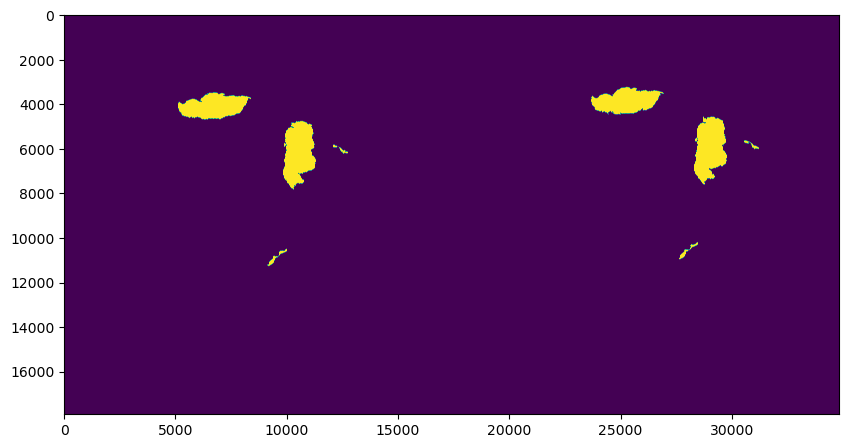

In [8]:
tumor_mask = open_slide(tumor_mask_path)
# Example: read the entire msliask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=2, 
                        width=tumor_mask.level_dimensions[2][0], 
                        height=tumor_mask.level_dimensions[2][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

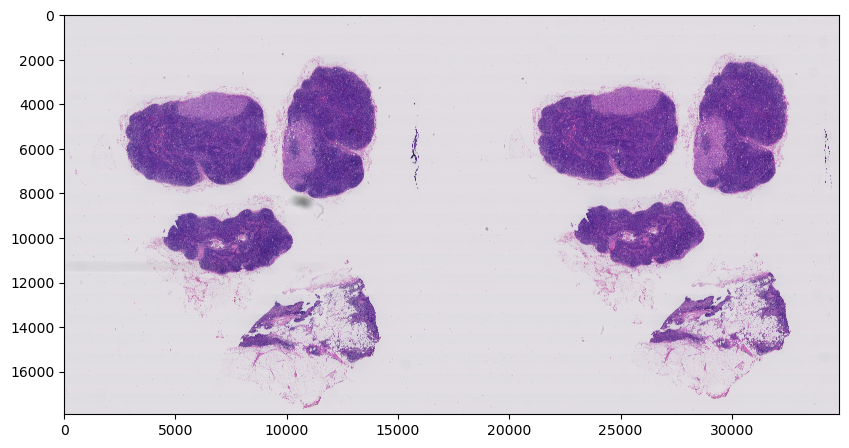

In [9]:
slide = open_slide(slide_path)
# Example: read the entire mask at the same zoom level
slide_image = read_slide(slide, 
                        x=0, 
                        y=0, 
                        level=2, 
                        width=slide.level_dimensions[2][0], 
                        height=slide.level_dimensions[2][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
# mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [11]:
del slide_image

In [10]:
slide_windows1, slide_windows2 = preprocess(np.array(slide_windows1)), preprocess(np.array(slide_windows2))


In [50]:
slide_windows1.shape

(5624, 299, 299, 3)

In [11]:
test_ds1 = create_test_tfdataset(slide_windows1[0:len(slide_windows1)//2], slide_windows2[0:len(slide_windows1)//2])

In [12]:
pred1 = new_model.predict(test_ds1, verbose = 1)

2022-12-22 23:31:48.041655: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


703/703 [==============================] - 43s 48ms/step


In [13]:
del test_ds1

In [14]:
test_ds2 = create_test_tfdataset(slide_windows1[len(slide_windows1)//2:], 
                                 slide_windows2[len(slide_windows1)//2:])


In [52]:
del test_ds2

In [15]:
pred2 = new_model.predict(test_ds2, verbose = 1)

703/703 [==============================] - 37s 48ms/step


In [21]:
pred1.shape

(2812, 1)

In [18]:
pred = np.concatenate([pred1, pred2])

In [19]:
pred.shape

(5624, 1)

In [114]:
heatmap = np.zeros_like(mask_image)

In [115]:
class_pred = generate_heat_map(new_model, pred, coord_1, heatmap, 0.8)

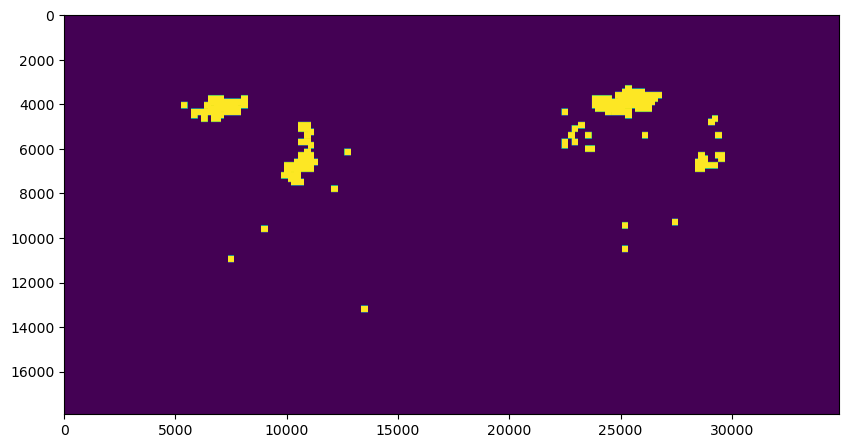

In [116]:
plt.figure(figsize=(10,10), dpi=100)
plt.grid(False)
plt.imshow(heatmap)

# Evaluate 

In [41]:
class_pred = np.array(class_pred)

In [42]:
label = np.array(window_labels)

accuracy: 0.9125177809388336
AUC for ROC Curve :0.6455039810754674


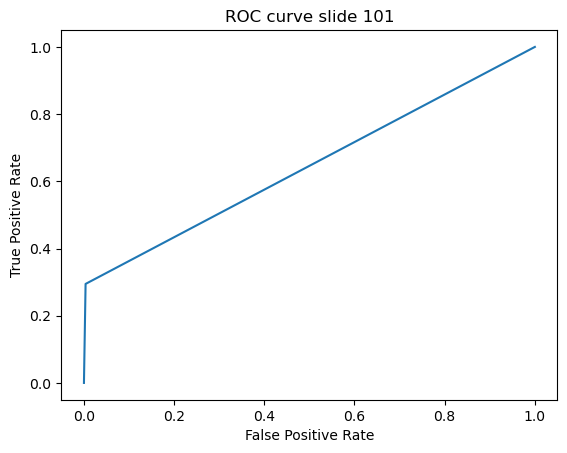

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4952
           1       0.92      0.29      0.45       672

    accuracy                           0.91      5624
   macro avg       0.91      0.65      0.70      5624
weighted avg       0.91      0.91      0.89      5624



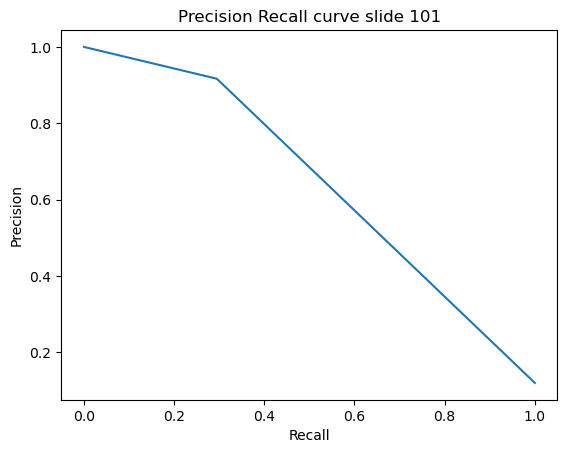

AUC for Precision Recall Curve :0.6477955869403237 


In [138]:
evaluate(label, class_pred, "slide 101")

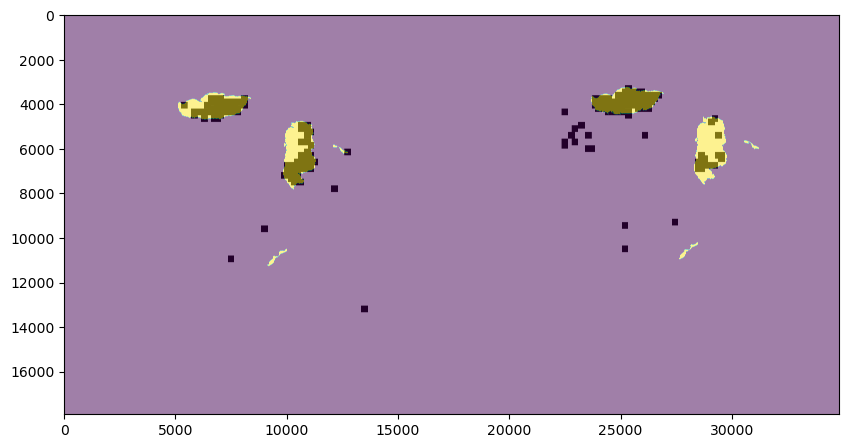

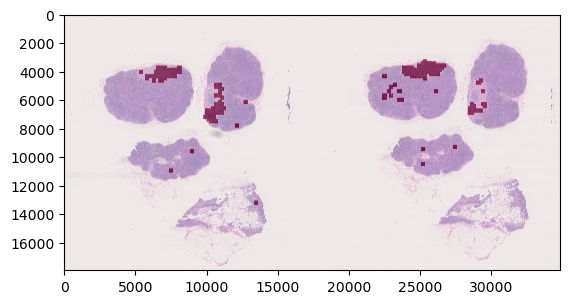

In [131]:
 draw_overlap(mask_image, heatmap, slide_image)